<a href="https://colab.research.google.com/github/TQT2203/btvn/blob/main/BTVN_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow opencv-python matplotlib scikit-learn


In [2]:
from google.colab import files
import zipfile
import os

# Tải file ZIP từ máy lên Colab
uploaded = files.upload()  # Chọn file .zip của bạn

# Giải nén file ZIP
for filename in uploaded.keys():
    zip_path = filename
    extract_folder = filename.replace(".zip", "")

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

    print(f"✅ Giải nén hoàn tất vào thư mục: {extract_folder}")

# Kiểm tra thư mục đã giải nén
os.listdir(extract_folder)

Saving dataset.zip to dataset.zip
✅ Giải nén hoàn tất vào thư mục: dataset


['dataset_emotion', 'dataset_person']

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os

In [16]:
def load_dataset(dataset_path, img_size):
    data = []
    labels = []
    label_map = {}
    label_id = 0

    # Get a list of all subdirectories (representing classes) in the dataset path
    class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    # Set the number of classes based on the number of subdirectories
    num_classes = len(class_folders)

    for folder in class_folders:  # Iterate through class folders
        folder_path = os.path.join(dataset_path, folder)

        label_map[label_id] = folder.lower()  # Map label ID to folder name

        for file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            face = cv2.resize(gray, (img_size, img_size))
            data.append(face)
            labels.append(label_id)  # Assign label ID to the image

        label_id += 1  # Move to the next label ID

    X = np.array(data).reshape(-1, img_size, img_size, 1) / 255.0
    y = to_categorical(labels, num_classes=num_classes)  # One-hot encode labels
    return X, y, label_map, num_classes

In [17]:
def create_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')  # Output layer with num_classes neurons
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [33]:
IMG_SIZE = 100

print("🚀 Huấn luyện nhận diện người...")
X_p, y_p, label_map_person, num_classes_person = load_dataset("/content/dataset/dataset_person", IMG_SIZE)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

model_person = create_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes_person)
model_person.fit(X_train_p, y_train_p, epochs=60, validation_data=(X_test_p, y_test_p))
model_person.save("model_person.h5")

🚀 Huấn luyện nhận diện người...
Epoch 1/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.4132 - loss: 1.6131 - val_accuracy: 0.3000 - val_loss: 2.0088
Epoch 2/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.4340 - loss: 1.4822 - val_accuracy: 0.5000 - val_loss: 1.4170
Epoch 3/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.3368 - loss: 1.3094 - val_accuracy: 0.5000 - val_loss: 1.2751
Epoch 4/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.5475 - loss: 1.2215 - val_accuracy: 0.3000 - val_loss: 1.2714
Epoch 5/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.5868 - loss: 1.1597 - val_accuracy: 0.3000 - val_loss: 1.3353
Epoch 6/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.4896 - loss: 1.0757 - val_accuracy: 0.3000 - val_loss: 1.3813
Epoch 7/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.5475 - loss: 0.9382 - val_accuracy: 0.3000 - val_loss: 1.3303
Epoch 8/60
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.6817 - loss: 0.8041 - 

In [21]:
print("\n🚀 Huấn luyện nhận diện cảm xúc...")
X_e, y_e, label_map_emotion, num_classes_emotion = load_dataset("/content/dataset/dataset_emotion", IMG_SIZE)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X_e, y_e, test_size=0.2, random_state=42)

model_emotion = create_cnn((IMG_SIZE, IMG_SIZE, 1), num_classes_emotion)
model_emotion.fit(X_train_e, y_train_e, epochs=100, validation_data=(X_test_e, y_test_e))
model_emotion.save("model_emotion.h5")


🚀 Huấn luyện nhận diện cảm xúc...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3103 - loss: 1.0878 - val_accuracy: 0.2500 - val_loss: 4.2476
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step - accuracy: 0.3793 - loss: 2.8289 - val_accuracy: 0.2500 - val_loss: 2.1662
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step - accuracy: 0.4138 - loss: 2.1777 - val_accuracy: 0.5000 - val_loss: 1.7293
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step - accuracy: 0.3103 - loss: 2.5024 - val_accuracy: 0.5000 - val_loss: 1.2023
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - accuracy: 0.3103 - loss: 1.3735 - val_accuracy: 0.5000 - val_loss: 1.0942
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4828 - loss: 1.0213 - val_accuracy: 0.2500 - val_loss: 1.3057
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step - accuracy: 0.6552 - loss: 0.8616 - val_accuracy: 0.2500 - val_loss: 1.3818
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6207 - loss: 0.8563 - val_accuracy: 0.1250 - val_loss: 1.3010
Ep

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
👉 Đây là THÁI và đang cảm thấy NORMAL


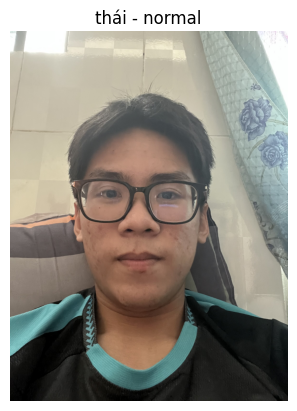

In [27]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
    input_face = face.reshape(1, IMG_SIZE, IMG_SIZE, 1) / 255.0

    pred_person = model_person.predict(input_face)
    name = label_map_person[np.argmax(pred_person)]

    pred_emotion = model_emotion.predict(input_face)
    emotion = label_map_emotion[np.argmax(pred_emotion)]

    print(f"👉 Đây là {name.upper()} và đang cảm thấy {emotion.upper()}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{name} - {emotion}")
    plt.axis("off")
    plt.show()
predict_image("/content/IMG_1627.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
👉 Đây là TRƯỜNG và đang cảm thấy SAD


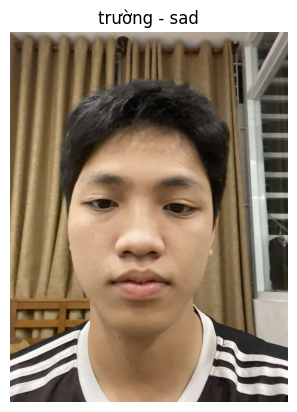

In [34]:
predict_image("/content/Tr.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
👉 Đây là LỘC và đang cảm thấy HAPPY


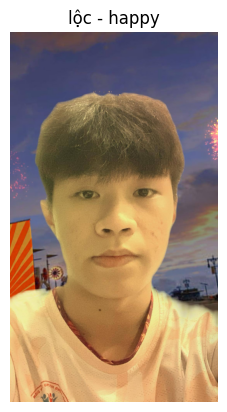

In [32]:
predict_image("/content/Loc.jpg")